# VI/PI CartPole

In [11]:

import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import time
import random
from itertools import product

# ------------------------------
# Global config
# ------------------------------
GAMMA = 0.99
N_SAMPLES = 20_000          # env steps to build MDP per seed
N_EVAL_EPISODES = 50        # episodes to estimate return per policy/seed
MAX_EVAL_STEPS = 500
SEED_LIST = list(range(1, 3))   # 10 seeds: 1..10
BIN_LIST = [2, 3, 4]        # base grid sizes; actual n_bins = [b, b, 2b, 2b]

print("Seed list:", SEED_LIST)
print("Bin list:", BIN_LIST)

Seed list: [1, 2]
Bin list: [2, 3, 4]


In [12]:

def set_seed(seed: int):
    np.random.seed(seed)
    random.seed(seed)

TERMINAL = (-1, -1, -1, -1)

def make_n_bins(b: int):
    """Map scalar grid size to per-dimension bins (reuse your pattern)."""
    return [b, b, 2 * b, 2 * b]

def build_states(n_bins_vec):
    states = list(product(*(range(n) for n in n_bins_vec)))
    states.append(TERMINAL)
    return states

def get_cartpole_bounds(env):
    low = env.observation_space.low.astype(np.float64).copy()
    high = env.observation_space.high.astype(np.float64).copy()
    # Cap unbounded dimensions (like your code)
    low[1] = -3.0
    high[1] = 3.0
    low[3] = -3.0
    high[3] = 3.0
    return low, high

def discretize_state(obs, n_bins_vec, state_low, state_high):
    ratios = (obs - state_low) / (state_high - state_low)
    ratios = np.clip(ratios, 0.0, 0.9999)
    bins = [int(r * n) for r, n in zip(ratios, n_bins_vec)]
    return tuple(bins)

def estimate_cartpole_transitions(env, n_bins_vec, n_samples=N_SAMPLES):
    """
    Estimate deterministic transition model P, R using random exploration.
    Reuses your idea: reward is always 1 per step, deterministic next-state.
    """
    P = {}
    R = {}
    low, high = get_cartpole_bounds(env)

    for _ in range(n_samples):
        obs, _ = env.reset()
        done = False
        while not done:
            s = discretize_state(obs, n_bins_vec, low, high)
            a = env.action_space.sample()  # random for coverage
            next_obs, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            s2 = TERMINAL if done else discretize_state(next_obs, n_bins_vec, low, high)

            # deterministic transition
            P.setdefault((s, a), {})
            P[(s, a)][s2] = 1.0
            R[(s, a)] = 1.0  # CartPole reward is 1 per step
            obs = next_obs

    return P, R, low, high

# ------------------------------
# Value Iteration
# ------------------------------

def value_iteration(states, actions, P, R, gamma=GAMMA, delta=1e-4, patience=3):
    V = {s: 0.0 for s in states}
    V[TERMINAL] = 0.0
    policy = {s: 0 for s in states}

    deltas = []
    no_improve = 0

    while True:
        max_diff = 0.0
        V_new = {}
        for s in states:
            if s == TERMINAL:
                V_new[s] = 0.0
                continue

            q_vals = []
            for a in actions:
                q = R.get((s, a), 0.0)
                if (s, a) in P:
                    for s2, p in P[(s, a)].items():
                        q += gamma * p * V.get(s2, 0.0)
                q_vals.append(q)

            V_new[s] = max(q_vals)
            policy[s] = int(np.argmax(q_vals))
            max_diff = max(max_diff, abs(V_new[s] - V.get(s, 0.0)))

        V = V_new
        deltas.append(max_diff)

        if max_diff < delta:
            no_improve += 1
        else:
            no_improve = 0

        if no_improve >= patience:
            break

    return V, policy, deltas

# ------------------------------
# Policy Iteration
# ------------------------------

def policy_iteration(states, actions, P, R, gamma=GAMMA,
                     eval_tol=1e-4, max_eval_iters=1_000):
    # init random policy
    policy = {}
    for s in states:
        if s == TERMINAL:
            policy[s] = 0
        else:
            policy[s] = random.choice(actions)

    V = {s: 0.0 for s in states}
    V[TERMINAL] = 0.0

    delta_list = []
    policy_changes_list = []

    while True:
        # Save old V for ΔV over outer iterations
        V_before = V.copy()

        # Policy evaluation (iterative)
        for _ in range(max_eval_iters):
            max_diff = 0.0
            for s in states:
                if s == TERMINAL:
                    continue
                a = policy[s]
                v_old = V[s]
                q = R.get((s, a), 0.0)
                if (s, a) in P:
                    for s2, p in P[(s, a)].items():
                        q += gamma * p * V[s2]
                V[s] = q
                max_diff = max(max_diff, abs(V[s] - v_old))
            if max_diff < eval_tol:
                break

        delta_outer = max(abs(V[s] - V_before[s]) for s in states)
        delta_list.append(delta_outer)

        # Policy improvement
        policy_stable = True
        n_changes = 0
        for s in states:
            if s == TERMINAL:
                continue
            old_a = policy[s]
            q_vals = []
            for a in actions:
                q = R.get((s, a), 0.0)
                if (s, a) in P:
                    for s2, p in P[(s, a)].items():
                        q += gamma * p * V[s2]
                q_vals.append(q)
            best_a = int(np.argmax(q_vals))
            policy[s] = best_a
            if best_a != old_a:
                policy_stable = False
                n_changes += 1

        policy_changes_list.append(n_changes)

        if policy_stable:
            break

    return V, policy, delta_list, policy_changes_list

# ------------------------------
# Policy evaluation (returns)
# ------------------------------

def evaluate_policy(env, policy, n_bins_vec, state_low, state_high,
                    n_episodes=N_EVAL_EPISODES, max_steps=MAX_EVAL_STEPS):
    returns = []
    for _ in range(n_episodes):
        obs, _ = env.reset()
        done = False
        total_r = 0.0
        steps = 0
        while not done and steps < max_steps:
            s = discretize_state(obs, n_bins_vec, state_low, state_high)
            a = policy.get(s, 0)
            obs, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            total_r += r
            steps += 1
        returns.append(total_r)
    return np.array(returns)

# ------------------------------
# Plot helpers
# ------------------------------

def plot_convergence_with_band(curves, title, ylabel, filename, ylog=True):
    """
    curves: list of 1D numpy arrays (one per seed).
    Aggregates with mean + IQR band.
    """
    if len(curves) == 0:
        return

    max_len = max(len(c) for c in curves)
    mat = np.full((len(curves), max_len), np.nan)
    for i, c in enumerate(curves):
        mat[i, :len(c)] = c

    mean = np.nanmean(mat, axis=0)
    q25 = np.nanpercentile(mat, 25, axis=0)
    q75 = np.nanpercentile(mat, 75, axis=0)

    iters = np.arange(max_len)

    plt.figure(figsize=(6, 4))
    plt.plot(iters, mean, label="mean")
    plt.fill_between(iters, q25, q75, alpha=0.3, label="IQR")
    if ylog:
        plt.yscale("log")
    plt.xlabel("Iteration")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

def mean_and_ci(vals, alpha=0.95):
    vals = np.array(vals, dtype=float)
    m = np.mean(vals)
    if len(vals) <= 1:
        return m, 0.0
    se = np.std(vals, ddof=1) / np.sqrt(len(vals))
    # approx 95% CI
    return m, 1.96 * se

def make_value_heatmap(V, n_bins_vec, filename,
                       angle_idx=2, angvel_idx=3):
    """
    V: dict of state -> value
    n_bins_vec: [bins_x, bins_xdot, bins_theta, bins_thetadot]
    Produces a 2D heatmap over (angle, angular velocity).
    """
    H = n_bins_vec[angle_idx]
    W = n_bins_vec[angvel_idx]

    value_map = np.zeros((H, W))
    counts = np.zeros((H, W))

    for s, val in V.items():
        if s == TERMINAL:
            continue
        i = s[angle_idx]
        j = s[angvel_idx]
        value_map[i, j] += val
        counts[i, j] += 1

    # avoid division by zero
    value_map = np.divide(value_map, counts,
                          out=np.zeros_like(value_map),
                          where=counts != 0)

    plt.figure(figsize=(6, 5))
    plt.imshow(value_map, origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(label='Value V(s)')
    plt.xlabel('Pole Angular Velocity')
    plt.ylabel('Pole Angle')
    plt.title('Value Function Heatmap')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

def median_and_iqr(vals):
    vals = np.array(vals, dtype=float)
    med = np.median(vals)
    q25 = np.percentile(vals, 25)
    q75 = np.percentile(vals, 75)
    return med, q25, q75


def plot_median_iqr(x, y_dict, ylabel, title, filename, label):
    """
    x: list of bin sizes
    y_dict: {b: [time_seed1, time_seed2, ...]}
    """
    meds, q25s, q75s = [], [], []

    for b in x:
        med, q25, q75 = median_and_iqr(y_dict[b])
        meds.append(med)
        q25s.append(q25)
        q75s.append(q75)

    x = np.array(x, dtype=float)

    plt.figure(figsize=(6, 4))
    plt.plot(x, meds, "-o", label=f"{label} (med)")
    plt.fill_between(x, q25s, q75s, alpha=0.3, label="IQR")

    plt.xlabel("Base grid size (b)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()




=== Running for base n_bins = 2 ===
  Seed 1
  Seed 2

=== Running for base n_bins = 3 ===
  Seed 1
  Seed 2

=== Running for base n_bins = 4 ===
  Seed 1
  Seed 2

Total wall-clock over all bins & seeds (VI+PI): 13.83 s

Plotting convergence for VI and PI using n_bins base = 4


/home/justin/miniforge3/envs/sl_report_env/lib/python3.13/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/justin/miniforge3/envs/sl_report_env/lib/python3.13/site-packages/numpy/lib/function_base.py:4658: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,
/home/justin/miniforge3/envs/sl_report_env/lib/python3.13/site-packages/matplotlib/scale.py:255: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


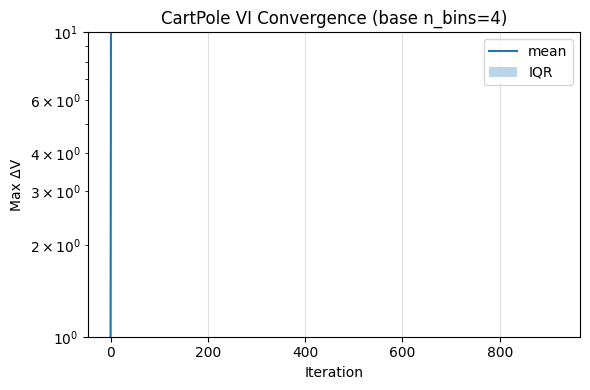

/home/justin/miniforge3/envs/sl_report_env/lib/python3.13/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


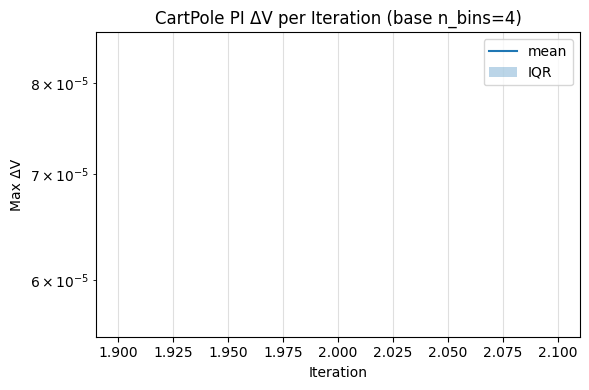

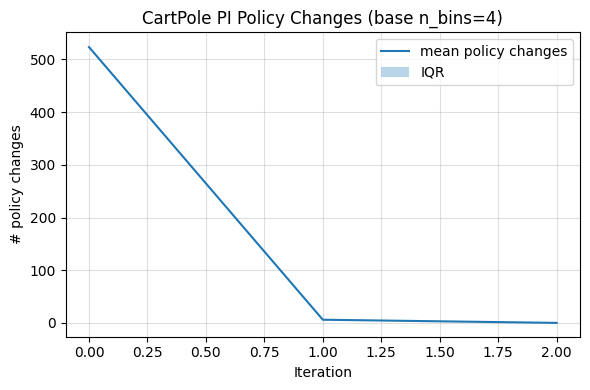

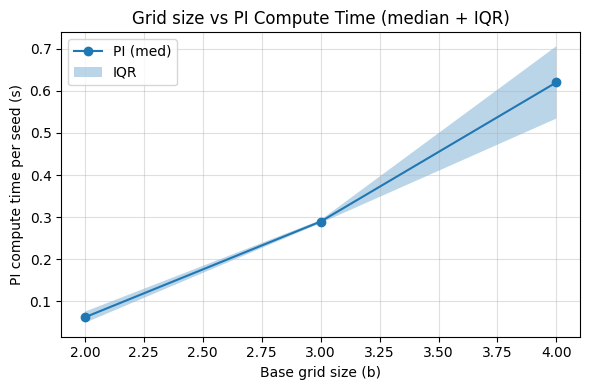

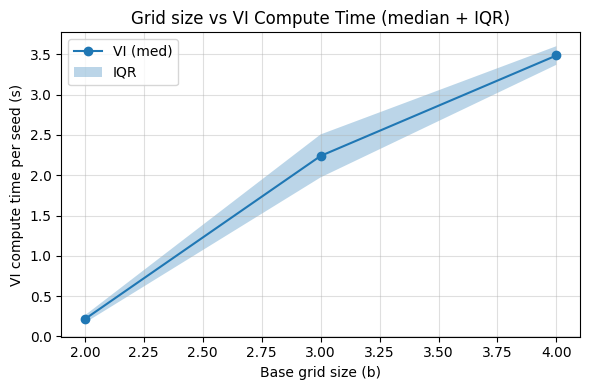

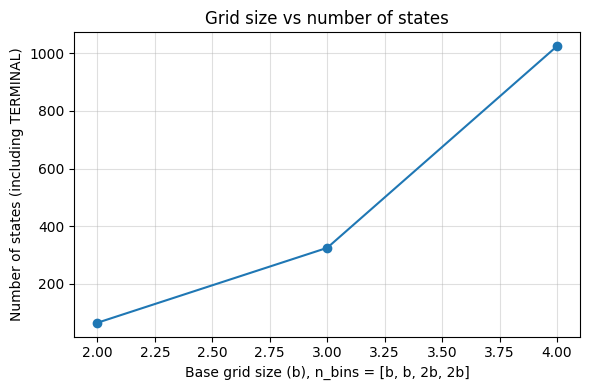

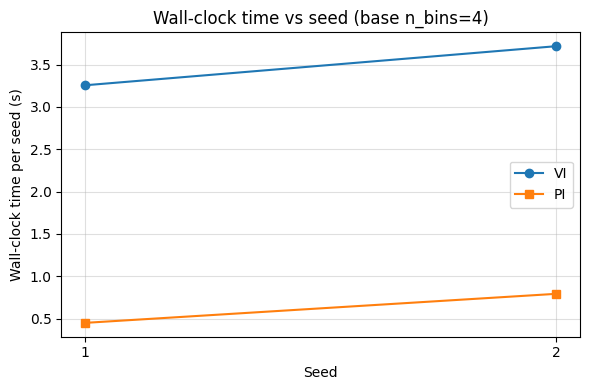

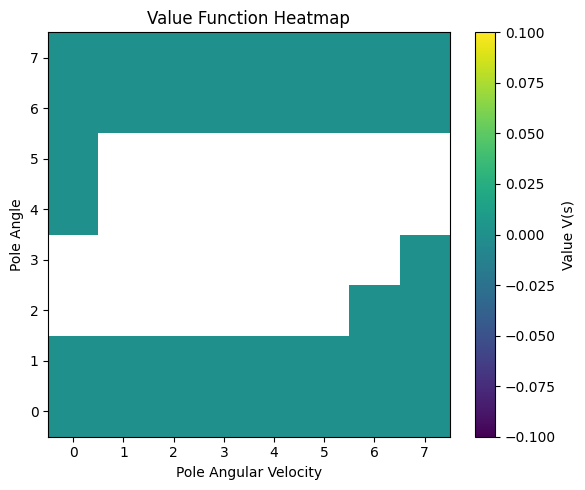

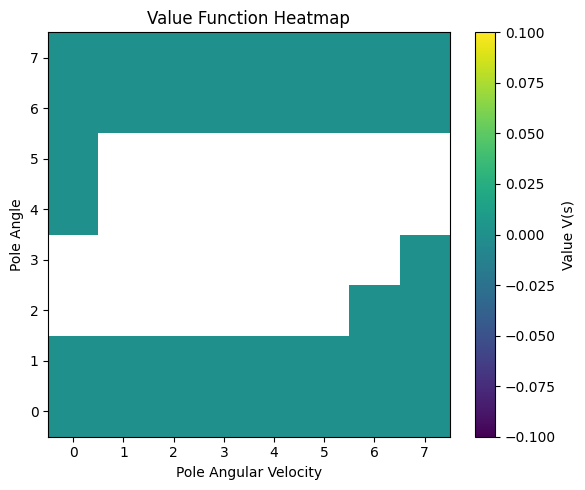


Done. Figures saved as:
  - cartpole_vi_deltaV_nbins*.pdf
  - cartpole_pi_deltaV_nbins*.pdf
  - cartpole_pi_policy_changes_nbins*.pdf
  - cartpole_grid_vs_return.pdf
  - cartpole_grid_vs_computetime.pdf
  - cartpole_grid_vs_states.pdf
  - cartpole_wallclock_vs_seed.pdf


In [13]:
actions = [0, 1]

all_vi_deltas = {}           # bin -> list of arrays (seeds)
all_pi_deltas = {}
all_pi_changes = {}
vi_returns_per_bin = {}      # bin -> list of avg return per seed
pi_returns_per_bin = {}
vi_times_per_bin = {}        # bin -> list of times per seed
pi_times_per_bin = {}
states_per_bin = {}          # bin -> num states

total_wallclock = 0.0

for b in BIN_LIST:
    print(f"\n=== Running for base n_bins = {b} ===")
    n_bins_vec = make_n_bins(b)
    states = build_states(n_bins_vec)

    vi_deltas_seed = []
    pi_deltas_seed = []
    pi_changes_seed = []
    vi_returns_seed = []
    pi_returns_seed = []
    vi_times_seed = []
    pi_times_seed = []

    for seed in SEED_LIST:
        print(f"  Seed {seed}")
        set_seed(seed)
        env = gym.make("CartPole-v1")

        # Build MDP
        P, R, low, high = estimate_cartpole_transitions(env, n_bins_vec, N_SAMPLES)

        # --- Value Iteration ---
        t0 = time.time()
        V_vi, policy_vi, deltas_vi = value_iteration(states, actions, P, R, gamma=GAMMA)
        vi_time = time.time() - t0
        vi_times_seed.append(vi_time)
        total_wallclock += vi_time
        vi_deltas_seed.append(np.array(deltas_vi))

        # Evaluate VI policy
        returns_vi = evaluate_policy(env, policy_vi, n_bins_vec, low, high)
        vi_returns_seed.append(returns_vi.mean())

        # --- Policy Iteration ---
        t0 = time.time()
        V_pi, policy_pi, deltas_pi, changes_pi = policy_iteration(states, actions, P, R, gamma=GAMMA)
        pi_time = time.time() - t0
        pi_times_seed.append(pi_time)
        total_wallclock += pi_time
        pi_deltas_seed.append(np.array(deltas_pi))
        pi_changes_seed.append(np.array(changes_pi))

        # Evaluate PI policy
        returns_pi = evaluate_policy(env, policy_pi, n_bins_vec, low, high)
        pi_returns_seed.append(returns_pi.mean())

        env.close()

    # Store per-bin results
    all_vi_deltas[b] = vi_deltas_seed
    all_pi_deltas[b] = pi_deltas_seed
    all_pi_changes[b] = pi_changes_seed
    vi_returns_per_bin[b] = vi_returns_seed
    pi_returns_per_bin[b] = pi_returns_seed
    vi_times_per_bin[b] = vi_times_seed
    pi_times_per_bin[b] = pi_times_seed
    states_per_bin[b] = np.prod(n_bins_vec) + 1  # +1 for TERMINAL

print("\nTotal wall-clock over all bins & seeds (VI+PI): "
      f"{total_wallclock:.2f} s")

# ------------------------------
# 1) ΔV vs iterations (VI) – use best discretization (largest bin)
# ------------------------------
best_b = BIN_LIST[-1]
print(f"\nPlotting convergence for VI and PI using n_bins base = {best_b}")
plot_convergence_with_band(
    all_vi_deltas[best_b],
    title=f"CartPole VI Convergence (base n_bins={best_b})",
    ylabel="Max ΔV",
    filename=f"cartpole_vi_deltaV_nbins{best_b}.pdf",
    ylog=True,
)

# ------------------------------
# 2) ΔV vs iterations / policy changes vs iterations (PI)
# ------------------------------
plot_convergence_with_band(
    all_pi_deltas[best_b],
    title=f"CartPole PI ΔV per Iteration (base n_bins={best_b})",
    ylabel="Max ΔV",
    filename=f"cartpole_pi_deltaV_nbins{best_b}.pdf",
    ylog=True,
)

# Policy changes vs iterations
pi_changes_curves = all_pi_changes[best_b]
max_len = max(len(c) for c in pi_changes_curves)
mat = np.full((len(pi_changes_curves), max_len), np.nan)
for i, c in enumerate(pi_changes_curves):
    mat[i, :len(c)] = c

mean_changes = np.nanmean(mat, axis=0)
q25_changes = np.nanpercentile(mat, 25, axis=0)
q75_changes = np.nanpercentile(mat, 75, axis=0)
iters = np.arange(max_len)

plt.figure(figsize=(6, 4))
plt.plot(iters, mean_changes, label="mean policy changes")
plt.fill_between(iters, q25_changes, q75_changes, alpha=0.3, label="IQR")
plt.xlabel("Iteration")
plt.ylabel("# policy changes")
plt.title(f"CartPole PI Policy Changes (base n_bins={best_b})")
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.savefig(f"cartpole_pi_policy_changes_nbins{best_b}.pdf")
plt.show()

# ------------------------------
# 3) Discretization study
#    - Grid size vs average return
#    - Grid size vs compute time
#    - Grid size vs number of states
# ------------------------------

# Grid size vs average return (VI vs PI)
bins_x = np.array(BIN_LIST, dtype=float)
vi_means = []
vi_errs = []
pi_means = []
pi_errs = []

for b in BIN_LIST:
    m_vi, e_vi = mean_and_ci(vi_returns_per_bin[b])
    m_pi, e_pi = mean_and_ci(pi_returns_per_bin[b])
    vi_means.append(m_vi)
    vi_errs.append(e_vi)
    pi_means.append(m_pi)
    pi_errs.append(e_pi)

# plt.figure(figsize=(6, 4))
# plt.errorbar(bins_x, vi_means, yerr=vi_errs, fmt="-o", label="VI")
# plt.errorbar(bins_x, pi_means, yerr=pi_errs, fmt="-s", label="PI")
# plt.xlabel("Base grid size (b), n_bins = [b, b, 2b, 2b]")
# plt.ylabel("Average return (episodes)")
# plt.title("Grid size vs average return")
# plt.grid(True, alpha=0.4)
# plt.legend()
# plt.tight_layout()
# plt.savefig("cartpole_grid_vs_return.pdf")
# plt.show()
plot_median_iqr(
    BIN_LIST,
    pi_times_per_bin,
    ylabel="PI compute time per seed (s)",
    title="Grid size vs PI Compute Time (median + IQR)",
    filename="cartpole_grid_vs_computetime_pi_IQR.pdf",
    label="PI"
)

# Grid size vs compute time (VI vs PI)
vi_time_mean = []
vi_time_err = []
pi_time_mean = []
pi_time_err = []

for b in BIN_LIST:
    m_vi, e_vi = mean_and_ci(vi_times_per_bin[b])
    m_pi, e_pi = mean_and_ci(pi_times_per_bin[b])
    vi_time_mean.append(m_vi)
    vi_time_err.append(e_vi)
    pi_time_mean.append(m_pi)
    pi_time_err.append(e_pi)

# plt.figure(figsize=(6, 4))
# plt.errorbar(bins_x, vi_time_mean, yerr=vi_time_err, fmt="-o", label="VI")
# plt.errorbar(bins_x, pi_time_mean, yerr=pi_time_err, fmt="-s", label="PI")
# plt.xlabel("Base grid size (b), n_bins = [b, b, 2b, 2b]")
# plt.ylabel("Compute time per seed (s)")
# plt.title("Grid size vs compute time (VI vs PI)")
# plt.grid(True, alpha=0.4)
# plt.legend()
# plt.tight_layout()
# plt.savefig("cartpole_grid_vs_computetime.pdf")
# plt.show()
plot_median_iqr(
    BIN_LIST,
    vi_times_per_bin,
    ylabel="VI compute time per seed (s)",
    title="Grid size vs VI Compute Time (median + IQR)",
    filename="cartpole_grid_vs_computetime_vi_IQR.pdf",
    label="VI"
)

# # Grid size vs number of states
states_counts = [states_per_bin[b] for b in BIN_LIST]

plt.figure(figsize=(6, 4))
plt.plot(bins_x, states_counts, "-o")
plt.xlabel("Base grid size (b), n_bins = [b, b, 2b, 2b]")
plt.ylabel("Number of states (including TERMINAL)")
plt.title("Grid size vs number of states")
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.savefig("cartpole_grid_vs_states.pdf")
plt.show()

# ------------------------------
# 4) Wall-clock time vs seed (for best grid, VI and PI)
# ------------------------------
vi_times_seed_best = vi_times_per_bin[best_b]
pi_times_seed_best = pi_times_per_bin[best_b]

plt.figure(figsize=(6, 4))
plt.plot(SEED_LIST, vi_times_seed_best, "-o", label="VI")
plt.plot(SEED_LIST, pi_times_seed_best, "-s", label="PI")
plt.xlabel("Seed")
plt.ylabel("Wall-clock time per seed (s)")
plt.title(f"Wall-clock time vs seed (base n_bins={best_b})")
plt.grid(True, alpha=0.4)
plt.xticks(SEED_LIST)
plt.legend()
plt.tight_layout()
plt.savefig("cartpole_wallclock_vs_seed.pdf")
plt.show()

make_value_heatmap(V_vi, n_bins_vec, f"value_heatmap_vi_seed{seed}.pdf")
make_value_heatmap(V_pi, n_bins_vec, f"value_heatmap_pi_seed{seed}.pdf")


print("\nDone. Figures saved as:")
print("  - cartpole_vi_deltaV_nbins*.pdf")
print("  - cartpole_pi_deltaV_nbins*.pdf")
print("  - cartpole_pi_policy_changes_nbins*.pdf")
print("  - cartpole_grid_vs_return.pdf")
print("  - cartpole_grid_vs_computetime.pdf")
print("  - cartpole_grid_vs_states.pdf")
print("  - cartpole_wallclock_vs_seed.pdf")